## Algorithme génétique basé sur estimation de distribution

Un algorithme génétique basé sur l'estimation de distribution (EDA) fonctionne en créant un modèle probabiliste à partir des solutions prometteuses et en utilisant ce modèle pour générer de nouvelles solutions. Voici comment un tel algorithme fonctionne.

### Étapes d'un EDA :
1. Générer une population initiale.
2. Sélectionner les meilleures solutions.
3. Construire un modèle probabiliste.
4. Générer de nouvelles solutions à partir du modèle.
5. Répéter jusqu'à convergence.

In [123]:
# importation des bibliothèques
# Import des librairies/modules
from deap import base, creator, tools
import random
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [124]:
# Définition des paramètres
ONE_MAX_LENGTH = 200

# Paramètres AG
POPULATION_SIZE = 100
MAX_GENERATIONS = 500
WITH_TRAP = False

In [125]:
toolbox = base.Toolbox()
toolbox.register("zeroOrOne", random.randint, 0, 1)
toolbox.register("individualCreator", tools.initRepeat, creator.Individual, toolbox.zeroOrOne, ONE_MAX_LENGTH)
toolbox.register("populationCreator", tools.initRepeat, list, toolbox.individualCreator)

In [126]:
def oneMaxFitness(individual):
    if WITH_TRAP:
        return oneMaxFitnessWithTrap(individual)
    else:
        return (sum(individual),)

# trap(u) =
# 5 if u = ONE_MAX_LENGTH,
# ONE_MAX_LENGTH − u otherwise
def oneMaxFitnessWithTrap(individual):
    u = sum(individual)
    if u == ONE_MAX_LENGTH:
        return (u,)  # Récompense maximale lorsque toutes les valeurs sont égales à 1
    else:
        return ((ONE_MAX_LENGTH - 1) - u,)  # Pénalisation proportionnelle


# Enregistrement des fonctions de fitness
toolbox.register("evaluate", oneMaxFitness)
    

In [127]:
# fonction principale de l'EAD
def EAD():
    prob_vector = [0.5] * ONE_MAX_LENGTH
    # stockage de l'historique
    logbook = []
    for generation in range(MAX_GENERATIONS):
        population = []
        for i in range(POPULATION_SIZE):
            individual = creator.Individual([random.random() < prob for prob in prob_vector])
            population.append(individual)
        # Evaluation de la population
        fitnesses = list(map(toolbox.evaluate, population))
        for individual, fitness in zip(population, fitnesses):
            individual.fitness.values = fitness
        # selections des 10 meilleurs individus
        best_individuals = tools.selBest(population, 10)
        # Mise à jour du vecteur de probabilité
        for i in range(ONE_MAX_LENGTH):
            prob_vector[i] = sum([ind[i] for ind in best_individuals]) / 10
        # Collecte des statistiques
        max_fitness = max(fitnesses)[0]
        avg_fitness = np.mean([fit[0] for fit in fitnesses])
        logbook.append({"max": max_fitness, "avg": avg_fitness})

        # Affichage des statistiques pour chaque génération
        if generation % 100 == 0:
            print(f"Generation {generation}: Max Fitness = {max_fitness}, Avg Fitness = {avg_fitness}")

        # Condition d'arrêt si la solution optimale est trouvée
        if max_fitness == ONE_MAX_LENGTH:
            print(f"Solution optimale trouvée à la génération {generation} !")
            break  
    print(prob_vector)        
    return logbook

Generation 0: Max Fitness = 118, Avg Fitness = 101.44
Generation 100: Max Fitness = 195, Avg Fitness = 195.0
Generation 200: Max Fitness = 195, Avg Fitness = 195.0
Generation 300: Max Fitness = 195, Avg Fitness = 195.0
Generation 400: Max Fitness = 195, Avg Fitness = 195.0
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 

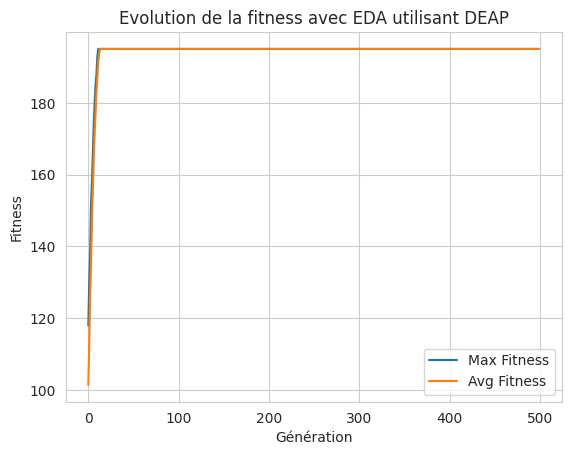

In [128]:
logbook = EAD()
def printEAD(logbook, title):
    gen_numbers = range(len(logbook))
    max_fitness_values = [record['max'] for record in logbook]
    avg_fitness_values = [record['avg'] for record in logbook]
    
    plt.plot(gen_numbers, max_fitness_values, label='Max Fitness')
    plt.plot(gen_numbers, avg_fitness_values, label='Avg Fitness')
    plt.xlabel('Génération')
    plt.ylabel('Fitness')
    plt.title(title)
    plt.legend()
    plt.show()
    
printEAD(logbook, "Evolution de la fitness avec EDA utilisant DEAP")    

#### Observation : certain bit reste bloqués a 0 du a un manque de diversification
On va donc créer le même algo en incluant un range entre 0.1 et 0.9 comme probailité pour les xi de prob_vector

In [129]:
def EAD_diversification():
    # Initialisation du vecteur de probabilité à 0.5 (chaque bit a une probabilité de 0.5 d'être 1)
    prob_vector = [0.5] * ONE_MAX_LENGTH

    # Liste pour stocker l'historique des statistiques
    logbook = []

    # Paramètre pour mutation du vecteur de probabilité
    mutation_rate = 0.1

    # Boucle des générations
    for generation in range(MAX_GENERATIONS):
        # Génération de la population à partir du vecteur de probabilité
        population = []
        for _ in range(POPULATION_SIZE):
            individual = creator.Individual([1 if random.random() < prob else 0 for prob in prob_vector])
            population.append(individual)

        # Évaluation de la fitness
        fitnesses = list(map(toolbox.evaluate, population))
        for ind, fit in zip(population, fitnesses):
            ind.fitness.values = fit

        # Sélection des meilleurs individus (50% les plus performants)
        sorted_population = tools.selBest(population, len(population) // 2)

        # Mise à jour du vecteur de probabilité basé sur les meilleurs individus
        for i in range(ONE_MAX_LENGTH):
            count_one = sum(ind[i] for ind in sorted_population)
            prob_vector[i] = count_one / len(sorted_population)

            # Ajouter une légère mutation au vecteur de probabilité pour éviter la stagnation
            if random.random() < mutation_rate:
                prob_vector[i] += random.uniform(-0.05, 0.05)

            # Limiter la valeur du vecteur de probabilité entre 0.1 et 0.9
            prob_vector[i] = min(0.9, max(0.1, prob_vector[i]))

        # Collecte des statistiques
        max_fitness = max(fitnesses)[0]
        avg_fitness = np.mean([fit[0] for fit in fitnesses])
        logbook.append({"max": max_fitness, "avg": avg_fitness})

        # Affichage des statistiques pour chaque génération
        if generation % 100 == 0:
            print(f"Generation {generation}: Max Fitness = {max_fitness}, Avg Fitness = {avg_fitness}")

        # Condition d'arrêt si la solution optimale est trouvée
        if max_fitness == ONE_MAX_LENGTH:
            print(f"Solution optimale trouvée à la génération {generation} !")
            break
    print(prob_vector)
    return logbook


Generation 0: Max Fitness = 119, Avg Fitness = 98.88
Generation 100: Max Fitness = 187, Avg Fitness = 175.39
Generation 200: Max Fitness = 188, Avg Fitness = 175.46
Generation 300: Max Fitness = 187, Avg Fitness = 174.74
Generation 400: Max Fitness = 184, Avg Fitness = 173.81
[0.9, 0.9, 0.84, 0.88, 0.9, 0.84, 0.9, 0.86, 0.9, 0.88, 0.88, 0.84, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.84, 0.88, 0.86, 0.8861798865706875, 0.7758790637812871, 0.8315357122441835, 0.9, 0.9, 0.8920402374734243, 0.9, 0.86, 0.9, 0.9, 0.88, 0.88, 0.9, 0.9, 0.9, 0.86, 0.88, 0.9, 0.9, 0.9, 0.9, 0.9, 0.86, 0.9, 0.9, 0.9, 0.84, 0.9, 0.88, 0.88, 0.88, 0.86, 0.9, 0.9, 0.9, 0.9, 0.86, 0.76, 0.9, 0.9, 0.9, 0.84, 0.9, 0.9, 0.86, 0.9, 0.9, 0.88, 0.9, 0.9, 0.9, 0.9, 0.82, 0.9, 0.9, 0.88, 0.9, 0.78, 0.9, 0.9, 0.86, 0.9, 0.84, 0.84, 0.82, 0.9, 0.84, 0.9, 0.86, 0.9, 0.88, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.84, 0.88, 0.84, 0.9, 0.82, 0.9, 0.9, 0.88, 0.88, 0.86, 0.9, 0.7908010055221386, 0.9, 0.8254352412395249, 0.806264454391

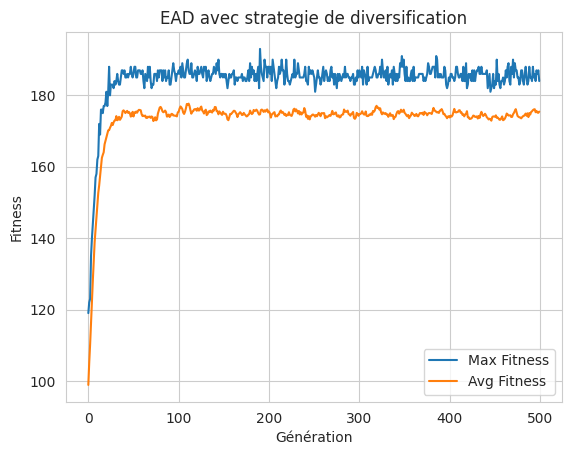

In [130]:
logbook = EAD_diversification()
printEAD(logbook, "EAD avec strategie de diversification")